In [40]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np 
import pandas as pd
from layers.ect import EctConfig, EctLayer
from layers.directions import generate_uniform_directions, generate_directions
import matplotlib.pyplot as plt
from torch_geometric.data import Batch, Data
import seaborn as sns



## Experiments on the loss function 

**Plots to make**
- Effect of number of directions on loss and gradient
- Effect of scale on loss function and gradient 



In [41]:
# Borrow from https://github.com/ThibaultGROUEIX/AtlasNet
def distChamfer(a, b):
    x, y = a, b
    bs, num_points, points_dim = x.size()
    xx = torch.bmm(x, x.transpose(2, 1))
    yy = torch.bmm(y, y.transpose(2, 1))
    zz = torch.bmm(x, y.transpose(2, 1))
    diag_ind = torch.arange(0, num_points).to(a).long()
    rx = xx[:, diag_ind, diag_ind].unsqueeze(1).expand_as(xx)
    ry = yy[:, diag_ind, diag_ind].unsqueeze(1).expand_as(yy)
    P = (rx.transpose(2, 1) + ry - 2 * zz)
    return (P.min(1)[0] + P.min(2)[0]).mean()

In [42]:
def get_target_batch(num_pts):
    # gen = torch.Generator(device="cpu").manual_seed(1)
    gen = None
    return Batch.from_data_list(
        [Data(x=0.1 *torch.randn(size=(num_pts, 3),generator=gen))]
    )

def get_pred_batch(num_pts,xs):
    # gen = torch.Generator(device="cpu").manual_seed(1)
    gen=None
    return Batch.from_data_list(
        [Data(x=xs + 0.1 *torch.randn(size=(num_pts, 3),generator=gen))]
    )


In [43]:
ECT_SIZE = 256
NUM_PTS = 1
NUM_RERUNS = 10

In [44]:
v = generate_uniform_directions(num_thetas=ECT_SIZE)
loss_layer = EctLayer(
    EctConfig(
        bump_steps=ECT_SIZE,
        num_thetas=ECT_SIZE,
        device="cpu",
        ect_type="points_derivative",
        normalized=True,
    ),
    v=v,
)

def ect_kld_loss(batch_pred,batch_target,scale):
    ect_pred = loss_layer(batch_pred, batch_pred.batch,scale)
    ect_target = loss_layer(batch_target, batch_target.batch,scale)
    ect_pred /= ect_pred.sum(axis=1, keepdim=True)
    ect_target /= ect_target.sum(axis=1, keepdim=True)
    eps = 10e-5
    ect_pred += eps
    ect_target += eps

    d = (
        F.kl_div(ect_pred.log(), ect_target, None, None, reduction="none")
        .sum(dim=-1)
        .sum(dim=-1)
        / NUM_PTS
    )
    return d


def cd_loss(batch_pred,batch_target,num_pts):
    pred = batch_pred.x.view(-1,num_pts,3)
    target=batch_target.x.view(-1,num_pts,3)
    d = distChamfer(pred,target)
    return d


def ect_mse_loss(batch_pred,batch_target,scale):
    ect_pred = loss_layer(batch_pred, batch_pred.batch,scale)
    ect_target = loss_layer(batch_target, batch_target.batch,scale)
    ect_pred /= ect_pred.sum(axis=1, keepdim=True)
    ect_target /= ect_target.sum(axis=1, keepdim=True)
    eps = 10e-5
    ect_pred += eps
    ect_target += eps

    d = F.mse_loss(ect_target, ect_pred)
    
    return d

# Vizualization of the different loss functions

We need to rerun this with confidence intervals, there seems to be quite some 
variance.


In [45]:
scale = 100
num_pts = 10
losses = []
for _ in range(NUM_RERUNS):
    xss = torch.linspace(-.7,.7,100)
    batch_target = get_target_batch(num_pts)
    losses_kld = []
    losses_mse = []
    losses_cd = []
    for xs in xss: 
        batch_pred = get_pred_batch(num_pts,xs)

        d_mse = ect_mse_loss(batch_pred,batch_target,scale)
        d_kld = ect_kld_loss(batch_pred,batch_target,scale)
        d_cd = cd_loss(batch_pred,batch_target,num_pts)
        
        losses.extend([
            {"xs":xs.item(), "loss":d_kld.item(),"type":"kld"},
            {"xs":xs.item(), "loss":d_cd.item(),"type":"cd"},
            {"xs":xs.item(), "loss":d_mse.item(),"type":"mse"}])
    # fig, axes = plt.subplots(1,3,figsize=(12,4))

    # ax = axes[0]
    # ax.set_title("ECT MSE Loss")
    # ax.plot(l_mse)
    # ax = axes[1]
    # ax.set_title("ECT KLD Loss")
    # ax.plot(l_kld)
    # ax = axes[2]
    # ax.set_title("CD Loss")
    # ax.plot(l_cd)


df_loss_fn = pd.DataFrame(losses)

In [46]:
df_loss_fn.head()

,xs,loss,type
0,-0.700000,1262.441650,kld
1,-0.700000,2.490380,cd
2,-0.700000,0.000335,mse
3,-0.685859,1243.614136,kld
4,-0.685859,2.365296,cd


<Axes: xlabel='xs', ylabel='loss'>

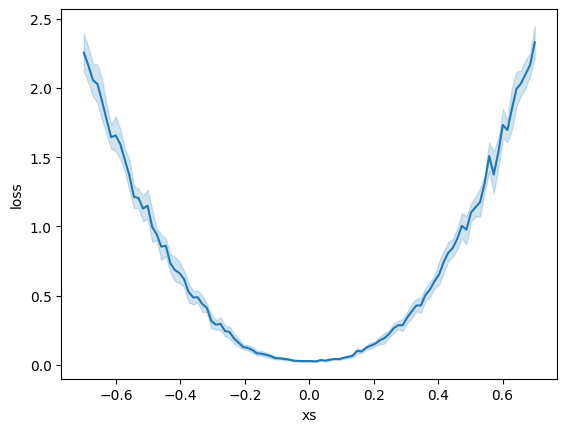

In [47]:
d = df_loss_fn[df_loss_fn["type"]=="cd"]
sns.lineplot(data=d, x="xs",y="loss")

<Axes: xlabel='xs', ylabel='loss'>

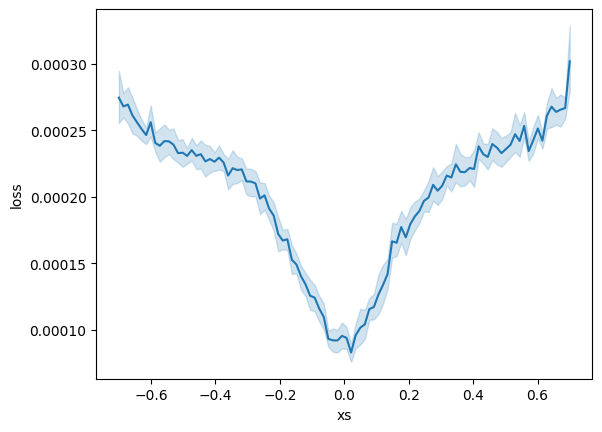

In [48]:
d = df_loss_fn[df_loss_fn["type"]=="mse"]
sns.lineplot(data=d, x="xs",y="loss")

<Axes: xlabel='xs', ylabel='loss'>

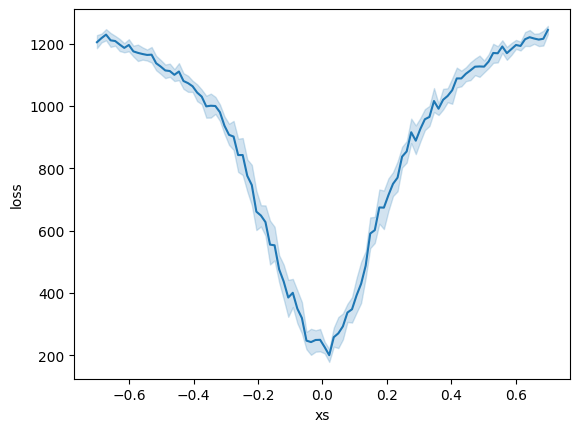

In [49]:
d = df_loss_fn[df_loss_fn["type"]=="kld"]
sns.lineplot(data=d, x="xs",y="loss")

# Visualization of the number of directions used in the ECT

In [50]:
import pandas as pd
losses =[]
for num_thetas in [8,16,32,64,128,256]:
    for _ in range(NUM_RERUNS): 
        scale = 100
        num_pts = 10
        xss = torch.linspace(-.7,.7,100)
        batch_target = get_target_batch(num_pts)

        v = generate_uniform_directions(num_thetas=num_thetas)
        loss_layer_vary = EctLayer(
            EctConfig(
                bump_steps=ECT_SIZE,
                num_thetas=num_thetas,
                device="cpu",
                ect_type="points_derivative",
                normalized=True,
            ),
            v=v,
        )
        def ect_kld_loss_vary(batch_pred,batch_target,scale):
            ect_pred = loss_layer_vary(batch_pred, batch_pred.batch,scale)
            ect_target = loss_layer_vary(batch_target, batch_target.batch,scale)
            ect_pred /= ect_pred.sum(axis=1, keepdim=True)
            ect_target /= ect_target.sum(axis=1, keepdim=True)
            eps = 10e-5
            ect_pred += eps
            ect_target += eps

            d = (
                F.kl_div(ect_pred.log(), ect_target, None, None, reduction="none")
                .sum(dim=-1)
                .sum(dim=-1)
            ) / NUM_PTS
            return d

        tmp = []
        for xs in xss: 
            batch_pred = get_pred_batch(num_pts,xs)
            d_kld = ect_kld_loss_vary(batch_pred,batch_target,scale)
            tmp.append(d_kld)
        
        # Normalize
        l = torch.tensor(tmp) / torch.tensor(tmp).abs().max()
        for x_norm, xs in zip(l,xss):
            losses.append({"loss":x_norm.item(),"xs":xs.item(),"num_thetas":num_thetas})


# fig, axes = plt.subplots(1,6,figsize=(24,4))

# for i,l in enumerate(losses):
#     ax = axes[i]
#     ax.set_title(f"ECT KLD Loss {i}")
#     ax.plot(l)


In [51]:
df = pd.DataFrame(losses)

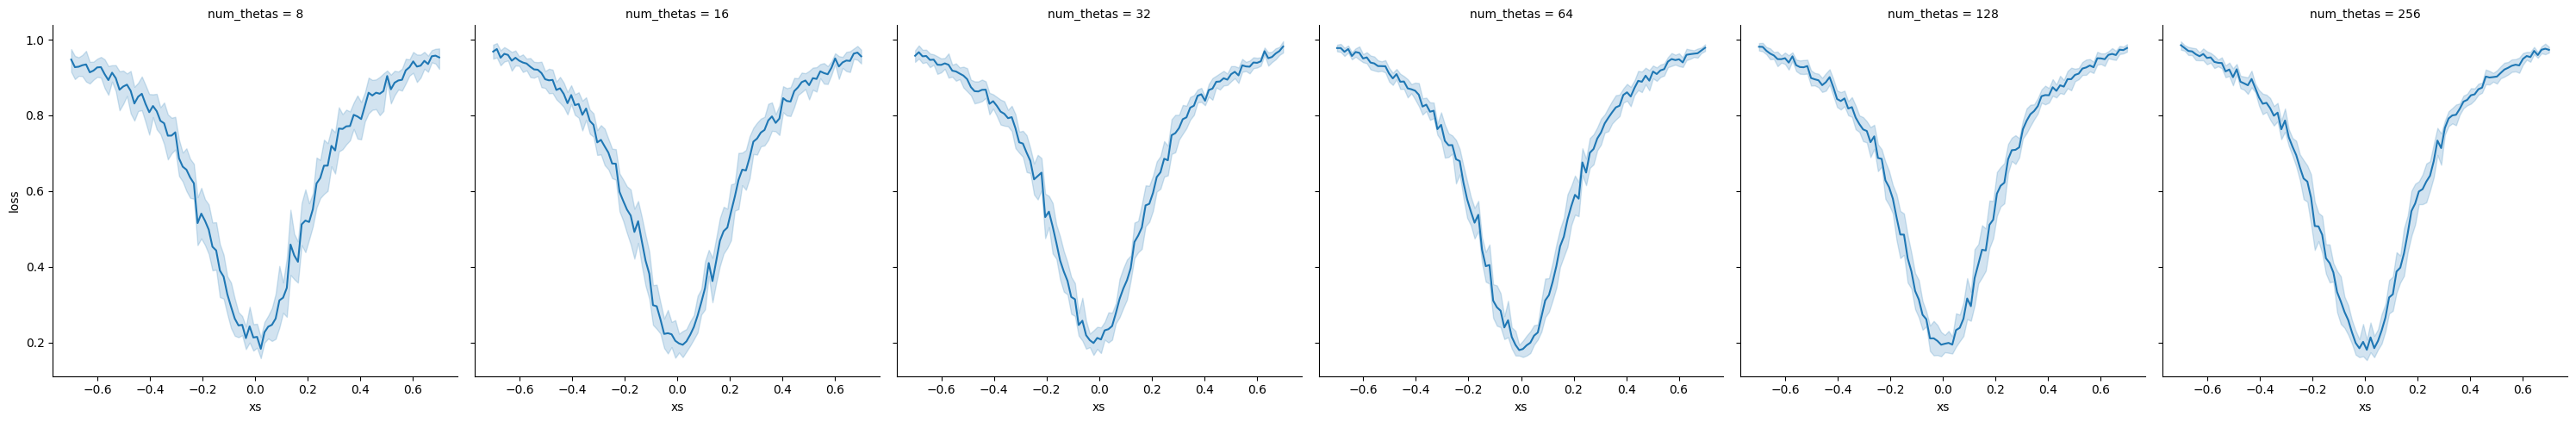

In [52]:
sns.relplot(
    data=df, x="xs", y="loss",
    col="num_thetas", #hue="event", style="event",
    kind="line"
)

# Resolution 

In [53]:
import pandas as pd
num_reruns = 10
num_thetas = ECT_SIZE
losses =[]
for bump_steps in [8,16,32,64,128,256]:
    for _ in range(NUM_RERUNS): 
        scale = 100
        num_pts = 10
        xss = torch.linspace(-.7,.7,100)
        batch_target = get_target_batch(num_pts)

        v = generate_uniform_directions(num_thetas=num_thetas)
        loss_layer_vary = EctLayer(
            EctConfig(
                bump_steps=bump_steps,
                num_thetas=ECT_SIZE,
                device="cpu",
                ect_type="points_derivative",
                normalized=True,
            ),
            v=v,
        )
        def ect_kld_loss_vary(batch_pred,batch_target,scale):
            ect_pred = loss_layer_vary(batch_pred, batch_pred.batch,scale)
            ect_target = loss_layer_vary(batch_target, batch_target.batch,scale)
            ect_pred /= ect_pred.sum(axis=1, keepdim=True)
            ect_target /= ect_target.sum(axis=1, keepdim=True)
            eps = 10e-5
            ect_pred += eps
            ect_target += eps

            d = (
                F.kl_div(ect_pred.log(), ect_target, None, None, reduction="none")
                .sum(dim=-1)
                .sum(dim=-1)
            ) / NUM_PTS
            return d

        tmp = []
        for xs in xss: 
            batch_pred = get_pred_batch(num_pts,xs)
            d_kld = ect_kld_loss_vary(batch_pred,batch_target,scale)
            tmp.append(d_kld)
        
        # Normalize
        l = torch.tensor(tmp) / torch.tensor(tmp).abs().max()
        for x_norm, xs in zip(l,xss):
            losses.append({"loss":x_norm.item(),"xs":xs.item(),"resolution":bump_steps})

df_bump_steps = pd.DataFrame(losses)


In [54]:
df_bump_steps.head()

,loss,xs,resolution
0,0.924166,-0.700000,8
1,0.903378,-0.685859,8
2,0.867095,-0.671717,8
3,0.893125,-0.657576,8
4,0.870249,-0.643434,8


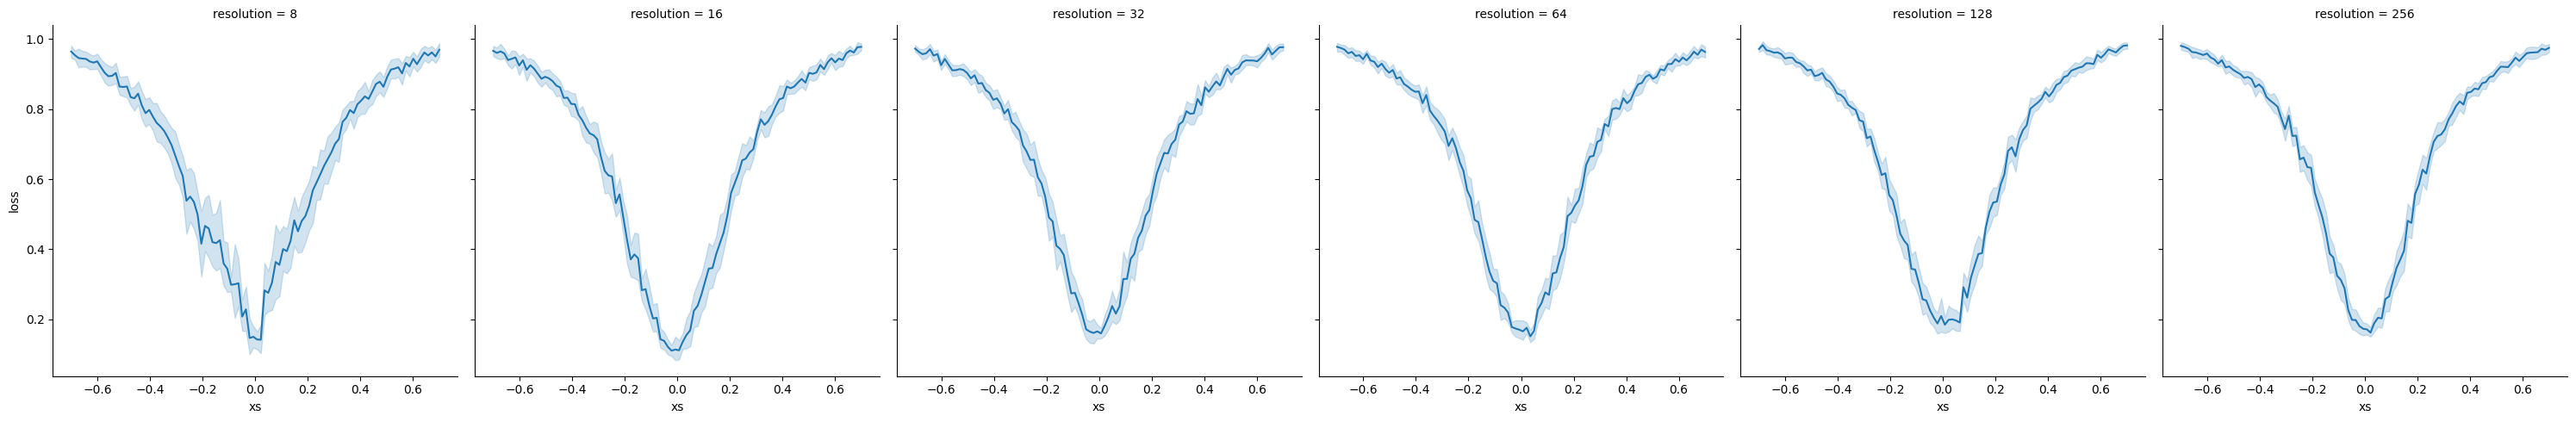

In [55]:
sns.relplot(
    data=df_bump_steps, x="xs", y="loss",
    col="resolution", #hue="event", style="event",
    kind="line"
)

In [56]:
# def plot_loss_mse(scale):
#     num_pts = 10
#     xss = torch.linspace(-.7,.7,100)
#     batch_target = get_target_batch(num_pts)
#     losses = []
#     for xs in xss: 
#         batch_pred = get_pred_batch(num_pts,xs)

#         d = ect_mse_loss(batch_pred,batch_target,scale)
#         losses.append(d)

#     l = torch.tensor(losses).numpy()
#     plt.plot(l)

In [57]:
# ipywidgets.interact(plot_loss_mse,scale=(1,200,.5))

In [58]:
# from torch import FloatTensor
# from torch.autograd import Variable

# NUM_PTS = 1
# NUM_THETAS = 1024
# BUMP_STEPS = 1024
# SCALE = 20




# grads = []
# losses = []

# v = generate_uniform_directions(num_thetas=NUM_THETAS)
# loss_layer = EctLayer(
#     EctConfig(
#         bump_steps=BUMP_STEPS,
#         num_thetas=NUM_THETAS,
#         device="cpu",
#         ect_type="points_derivative",
#         normalized=True,
#     ),
#     v=v,
# )

# def loss(batch_pred,batch_target,scale):
#     ect_pred = loss_layer(batch_pred, batch_pred.batch,scale)
#     ect_target = loss_layer(batch_target, batch_target.batch,scale)
#     ect_pred /= ect_pred.sum(axis=1, keepdim=True)
#     ect_target /= ect_target.sum(axis=1, keepdim=True)
#     eps = 10e-5
#     ect_pred += eps
#     ect_target += eps

#     # d = (
#     #     F.kl_div(ect_pred.log(), ect_target, None, None, reduction="none")
#     #     .sum(dim=-1)
#     #     .sum(dim=-1)
#     # )
#     d = F.mse_loss(ect_pred,ect_target)
#     return d

# pts = torch.ones(size=(NUM_PTS, 3))

# xss = torch.linspace(-.7,.7,200)
# batch_target = Batch.from_data_list([Data(x=.1*torch.rand(size=(NUM_PTS, 3))) ])


# for xs in xss:    
#     batch_pred = Batch.from_data_list([
#         Data(x= Variable(xs + .1 * torch.rand(size=(NUM_PTS, 3)),True))])

#     batch_pred.x.register_hook(lambda grad: grads.append(grad.norm(dim=-1)[0]))

#     d = loss(batch_pred,batch_target,SCALE)
#     d.backward()
#     losses.append(d) 

# losses = torch.tensor(losses).detach().cpu()
# g = torch.tensor(grads).cpu().detach()


# fig, axes = plt.subplots(1,2,figsize=(13,5))
# axes[0].plot(g)
# axes[1].plot(losses.numpy())

In [59]:
# plt
# losses.shape
# g.shape

In [60]:



# # Define the leaf nodes
# a = Variable(FloatTensor([4]))

# weights = [Variable(FloatTensor([i]), requires_grad=True) for i in (2, 5, 9, 7)]

# # unpack the weights for nicer assignment
# w1, w2, w3, w4 = weights

# b = w1 * a
# c = w2 * a
# d = w3 * b + w4 * c
# L = (10 - d)

# L.register_hook(lambda grad: print(grad)) 
# d.register_hook(lambda grad: print(grad)) 
# b.register_hook(lambda grad: print(grad)) 
# c.register_hook(lambda grad: print(grad)) 
# b.register_hook(lambda grad: print(grad)) 

# L.backward()




In [61]:
# batch_pred.x.grad

In [62]:
# for l in losses: 
#     l.backward()

In [63]:
# for p in batches[0].parameters():
#     print(p)

In [64]:
# scales = torch.linspace(0,2000, 50)
# print(len(scales))

In [65]:
# kld = []

# for scale in scales:
#     ect_pred = loss_layer(batch_pred, batch_pred.batch,scale).squeeze()
#     ect_target = loss_layer(batch_target, batch_target.batch,scale).squeeze()


#     eps = 10e-5
#     ect_pred /= ect_pred.sum(axis=1, keepdim=True)
#     ect_target /= ect_target.sum(axis=1, keepdim=True)
#     ect_pred += eps
#     ect_target += eps

#     d = (
#         F.kl_div(ect_pred.log(), ect_target, None, None, reduction="none")
#         .sum(dim=-1)
#         .sum(dim=-1)
#         / 2048
#     ).sum()
#     kld.append(d)


In [66]:
# import numpy as np 
# klp_arr = torch.tensor(kld).numpy()
# plt.plot(klp_arr)

In [67]:
# plt.imshow(ect_pred[0].squeeze().cpu().numpy())
# plt.show()
# plt.imshow(ect_target[0].squeeze().cpu().numpy())
# plt.show()

